In [1]:
import os
import re
import cv2
import numpy as np
from test_function import bgrExtraction
from pytesseract import Output
import pytesseract
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd = 'C:\\Users\\s\\AppData\\Local\\Programs\\Tesseract-OCR\\tesseract.exe'

## 출석부 관련
current_pth = os.path.expanduser("~") + "\\Downloads\\" # user 네임까지 가져오는 거
atten_dict = {
    'name' :[],
    'number': [],
}
with open(current_pth + '출석부.txt', 'r', encoding='utf-8') as f:
    atten_list = f.read().split('\n')
    for Human in atten_list:
        name, number = Human.split('\t')
        atten_dict['name'].append(name)
        atten_dict['number'].append(number)

In [2]:
config = ('-l kor --oem 3 --psm 13')
bgrLower = np.array([26, 26, 26])    # 추출할 색의 하한
bgrUpper = np.array([28, 30, 32])    # 추출할 색의 상한

image = cv2.imread('../../test_image.png')

bgrResult = bgrExtraction(image, bgrLower, bgrUpper)

blur = cv2.GaussianBlur(bgrResult, ksize=(5,5), sigmaX=0)
edged = cv2.Canny(blur,3,75)

contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
total = len(contours)
print(total)
contours_image= cv2.drawContours(image, contours, -1, (0, 255,0), 1)

41


In [3]:
gray_image_list =[]

for data in list(contours):
    x = []
    y = []
    for a in data:
        x.append(a[0][0])
        y.append(a[0][1])
    crop_img = image[ max(y)-20 : max(y) , min(x) : min(x) + 150 ] # 이름까지 추출

    gray_roi= cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    gray_image_list.append(gray_roi)

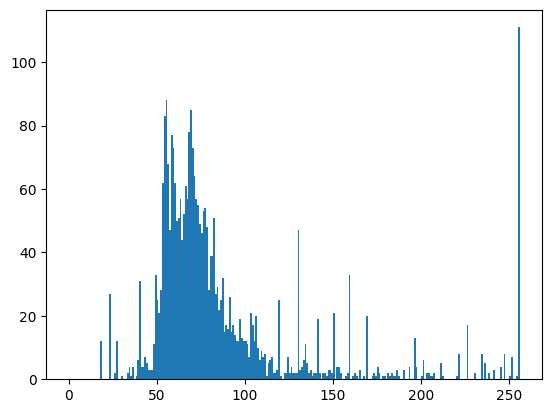

In [4]:
plt.hist(gray_image_list[0].ravel(), 256, [0, 256])
plt.show()

In [5]:
print(np.std(gray_image_list[0]))
print(np.mean(gray_image_list[0]))

50.699234750963775
89.173


In [6]:
## name ocr 안하고 number만 했을 경우
atten_list_index =[]
full_ocr = []

for data in list(contours):
    x = []
    y = []
    for a in data:
        x.append(a[0][0])
        y.append(a[0][1])
    crop_img = image[ max(y)-20 : max(y) , min(x) : min(x) + 125 ] # 이름까지 추출

    gray_roi= cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    gray_roi = np.where(gray_roi > 120, gray_roi, 0)

    full = pytesseract.image_to_string(gray_roi, config = config).rstrip()
    number = re.sub(r'[^0-9]', '', pytesseract.image_to_string(gray_roi,config=config,lang='kor').rstrip())
    if number in atten_dict['number']:
        atten_list_index.append(atten_dict['number'].index(number)) # 출석 한 사람 atten list에 넣기

    full_ocr.append(full)
## 인식이 확인 된 수
len(atten_list_index)

34

In [7]:
## number랑 name으로 했을 경우 
atten_list_index =[]
noinsic = []
for data in list(contours):
    x = []
    y = []
    for a in data:
        x.append(a[0][0])
        y.append(a[0][1])
    crop_img = image[ max(y)-20 : max(y) , min(x)+5 : min(x) + 125 ] # 이름까지 추출

    gray_roi= cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    gray_roi = np.where(gray_roi > 120, gray_roi, 0)

    number = re.sub(r'[^0-9]', '', pytesseract.image_to_string(gray_roi,config=config).rstrip())[:8]
    name = re.sub(r"[^ㄱ-ㅣ가-힣\s]", "", pytesseract.image_to_string(gray_roi, config = config).rstrip()).strip()

    if number in atten_dict['number']:
        atten_list_index.append(atten_dict['number'].index(number)) # 출석 한 사람 atten list에 넣기
    elif name in atten_dict['name']:
        atten_list_index.append(atten_dict['name'].index(name))
    else:
        noinsic.append(gray_roi)
    
# 인식이 확인된 수
print(len(atten_list_index))

40
